# Using a projectional method for reconstruction

This is code accompanying the paper [A Projectional Ansatz to Reconstruction](https://arxiv.org/abs/1907.04675).

## Basic idea
We want to solve the inverse problem
$$Ax + \eta = y + \eta = y^\delta,$$
where $A:X\to Y$ a continuous linear operator,
$\eta$ some noise with $||\eta||=\delta$ and we want to reconstuct $x$ from $y^\delta$.

## Approach
Train a neural network

$$G_\theta(A, y^\delta, \delta, x_0) := P_{\overline V(A, y^\delta, \delta)} \circ g_{\theta, n-1} \circ P_{\overline V(A, y^\delta, \delta)} \circ \cdots \circ g_{\theta, 0} \circ P_{\overline V(A, y^\delta, \delta)} (0),$$

where $P_\overline V$ the projection into the set
$$\overline V(A, y^\delta, \delta):= \{x\in X:\|Ax-y^\delta\|\le \delta\}$$

over a set of samples $(x, y^\delta)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create samples from some made up space X

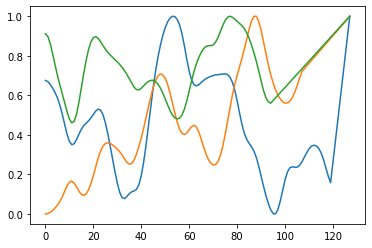

In [2]:
def get_batch(batch_size, function_length=128):
    n = function_length + 1
    fs = np.fft.irfft(np.random.normal(0, 1, [batch_size, n])*np.logspace(0,-8,n), axis=1)[:,:function_length]
    fs -= np.min(fs, axis=1).reshape(batch_size, 1)
    fs /= np.max(fs, axis=1).reshape(batch_size, 1)

    start_lin = np.random.rand(batch_size) * 64 + 64
    start_lin = start_lin.astype(int)
    for i in range(batch_size):
        fs[i, start_lin[i]:] = np.linspace(fs[i, start_lin[i]], 1, len(fs[i, start_lin[i]:]))

    return fs.T

def get_function(function_length=128):
    return get_batch(1, function_length=function_length).flatten()

for f in get_batch(3).T:
        plt.plot(f)
plt.show()

In [3]:
def get_noisy_batch(batch_size, relative_delta, function_length=1000):
    x = get_batch(batch_size, function_length=function_length)
    y = np.dot(A, x)

    delta = np.mean(np.linalg.norm(y, axis=0) * relative_delta)

    noise = np.random.normal(0, 1, y.shape)
    noise /= np.linalg.norm(noise, axis=0)
    noise *= delta

    y_delta = y + noise

    return y_delta, delta, x, y

In [4]:
function_length = 128
relative_delta = 1e-1
A = np.random.normal(0, 1, [function_length//2, function_length])

# L2 reconstruction code for comparison

In [5]:
from sklearn.linear_model import Ridge
def l2_reconstruction(A, y_delta, lamb):
    clf = Ridge(alpha=lamb)
    clf.fit(A, y_delta.flatten())
    return clf.coef_.flatten()

In [6]:
def get_best_l2(A, y_delta, x):
    best_lambda = 0
    best_i = 0
    best_rmse = np.inf

    n = 50

    for i, lamb in enumerate(np.logspace(-5, 5, n)):
        x_l2 = l2_reconstruction(A, y_delta, lamb)

        mse = np.linalg.norm(x - x_l2)**2
        rmse = mse / np.linalg.norm(x)**2

        if rmse < best_rmse:
            best_rmse = rmse
            best_lambda = lamb
            best_i = i

    lamb_min = np.logspace(-5, 5, n)[int(np.clip(best_i-1, 0, n-1))]
    lamb_max = np.logspace(-5, 5, n)[int(np.clip(best_i+1, 0, n-1))]

    for lamb in np.linspace(lamb_min, lamb_max, n):
        x_l2 = l2_reconstruction(A, y_delta, lamb)

        mse = np.linalg.norm(x - x_l2)**2
        rmse = mse / np.linalg.norm(x)**2

        if rmse <= best_rmse:
            best_rmse = rmse
            best_lambda = lamb

    return l2_reconstruction(A, y_delta, best_lambda)

# Load libs for Deep Learning part

In [7]:
import torch

from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

A_torch = torch.cuda.FloatTensor(A)
A_torch = A_torch.requires_grad_(False)

# CG-method implementation

In [8]:
def custom_torch_cg(A, mu, b, tol=1e-12, verbose=False):
    """
    CG method for Mx=b
    where M = 1 + mu * A.T A
    """
    def timesM(x):
        return x + mu * torch.mm(A.t(), torch.mm(A, x))

    x = torch.clone(b)

    r = b - timesM(x)
    p = r
    eps = tol * torch.norm(b)

    if torch.norm(r) <= eps:
        return x

    i = 0
    while True:
        i += 1
        Mp = timesM(p)
        alpha = torch.sum(r**2, dim=0) / torch.sum(p * Mp, dim=0)
        alpha_p = alpha * p
        if torch.any(torch.isnan(alpha_p)):
            if verbose:
                print("Stopped cg due to nan.")
            return x
        x = x + alpha_p
        old_r = r
        r = r - alpha * Mp
        if torch.norm(r) < eps:
            return x
        beta = torch.sum(r**2, dim=0) / torch.sum(old_r**2, dim=0)
        p = r + beta * p

# Code to projection an outside point onto an "ellipse"

In [9]:
def project_into_ellipse(x_star,
                         A, y_delta, delta,
                         verbose=True,
                         EPSILON_PRECESSION=1e-2,
                         EPSILON_CG=1e-12):
    """
    Projects x_star onto the ellipse given by ||Ax-y_delta|| = delta
    """

    # How far away from boundry (relative)?
    def error(x, y_delta, sign=False):
        Ax_y = torch.mm(A, x) - y_delta
        err = (torch.norm(Ax_y, dim=0) - delta) / delta
        if sign:
            return err
        else:
            return torch.abs(err)

    # Solve Minimization for a fixed mu.
    def solve(mu, x_star, y_delta):
        b = x_star + mu * torch.mm(A.t(), y_delta)
        return custom_torch_cg(A, mu, b,
                               tol=EPSILON_CG)

    # Iteratively update mu and return solution x for final mu
    def solve_with_binary(x_star, y_delta):
        mu_neg = torch.torch.ones_like(x_star[0])
        mu_pos = torch.torch.ones_like(x_star[0])

        i = 0

        def phi_dash(mu):
            x = solve(mu, x_star, y_delta)
            Ax_y = torch.mm(A, x) - y_delta
            return (torch.norm(Ax_y, dim=0) - delta) / delta

        while True:
            i += 1
            phi_dash_mu_pos = phi_dash(mu_pos)
            if torch.any(phi_dash_mu_pos < 0):
                mu_pos[phi_dash_mu_pos < 0] /= 2
            else:
                break

        while True:
            i += 1
            phi_dash_mu_neg = phi_dash(mu_neg)
            if torch.any(phi_dash_mu_neg > 0):
                mu_neg[phi_dash_mu_neg > 0] *= 2
            else:
                break

        mu_mid = (mu_neg + mu_pos) / 2
        i += 1
        phi_dash_mid = phi_dash(mu_mid)
        while torch.any(torch.abs(phi_dash_mid) > EPSILON_PRECESSION):
            mu_neg[phi_dash_mid < 0] = mu_mid[phi_dash_mid < 0]
            mu_pos[phi_dash_mid >= 0] = mu_mid[phi_dash_mid >= 0]
            mu_mid = (mu_neg + mu_pos) / 2
            phi_dash_mid = phi_dash(mu_mid)
            i += 1

        if verbose:
            print("Binary search took", i, "cg iterations.")

        return solve(mu_mid, x_star, y_delta)

    # Which ones need to be projected, since they are outside the ellipse
    active = error(x_star, y_delta, sign=True) > 0
    # If non need to be projected, we do not need to waste any more time on this.
    if not torch.any(active):
        return x_star

    # Calculate projections and return them.
    x = torch.clone(x_star)
    x[:,active] = solve_with_binary(x_star[:,active], y_delta[:,active])

    return x

In [10]:
def agile_project_into_ellipse(x_star,
                              A, y_delta, delta,
                              verbose=True,
                              EPSILON_PRECESSION=1e-2,
                              EPSILON_CG=1e-12,
                              precession=torch.float64):
    """
    Assumes first index of x_star and y_delta runs over the samples.
    Based on this assumption this wrapper for project_into_ellipse.
    """
    def to_matrix(x, dtype=None):
        if dtype is None:
            dtype = x.dtype
        return x.view(x.shape[0], -1).t().type(dtype)

    def from_matrix(x, sample_shape, dtype=None):
        if dtype is None:
            dtype = x.dtype
        return x.t().view(-1, *sample_shape).type(dtype)

    y_sample_shape = y_delta[0].shape
    x_sample_shape = x_star[0].shape

    x_matrix = project_into_ellipse(to_matrix(x_star).type(precession),
                                    A.type(precession),
                                    to_matrix(y_delta).type(precession),
                                    delta.type(precession),
                                    verbose=verbose,
                                    EPSILON_PRECESSION=EPSILON_PRECESSION,
                                    EPSILON_CG=EPSILON_CG)

    return from_matrix(x_matrix, x_sample_shape).type(x_star.dtype)

# Wrap the projection functionality into a layer

In [11]:
EPSILON_PRECESSION = 1e-2
EPSILON_CG = 1e-9

class Projection(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_star, A, y_delta, delta):
        # Project onto the ellipse this part can be replaced by any projection algorithm
        err = torch.norm(torch.mm(A, x_star.view(-1, A.shape[1]).t()) - y_delta.t(), dim=0) - delta
        active = err >= EPSILON_PRECESSION
        x = torch.clone(x_star)
        if torch.any(active):
            x[active] = agile_project_into_ellipse(x_star[active], A, y_delta[active], delta,
                                                   verbose=False,
                                                   EPSILON_PRECESSION=EPSILON_PRECESSION,
                                                   EPSILON_CG=EPSILON_CG)

        ctx.x_star = x_star
        ctx.A = A
        ctx.y_delta = y_delta
        ctx.delta = delta
        ctx.x = x
        ctx.active = active

        return x

    @staticmethod
    def backward(ctx, dLdf_t, epsilon=1e-3):
        # Define and transform variables s.t. every column represents a data point
        A = ctx.A 
        active = ctx.active
        x_star = ctx.x_star.view(-1, A.shape[1]).t()
        y_delta = ctx.y_delta.t()
        delta = ctx.delta
        x = ctx.x.view(-1, A.shape[1]).t()
        dLdf = dLdf_t.view(-1, A.shape[1]).t()

        # Calculate mu based on forward results
        ATAx_y = torch.matmul(A.t(), torch.matmul(A, x) - y_delta)
        mu = torch.norm(x_star - x, dim=0) / torch.norm(ATAx_y, dim=0)
        mu[torch.norm(torch.matmul(A, x_star) - y_delta, dim=0) <= delta] = 0.

        # Calculate gradients to pass on
        dLdx = torch.clone(dLdf)
        if torch.any(active):
            dLdx[:,active] = custom_torch_cg(A, mu[active], dLdf[:,active], EPSILON_CG)

        dLdx_t = dLdx.t().view(dLdf_t.size())
        del ctx.A, ctx.x_star, ctx.y_delta, ctx.delta, ctx.x

        return dLdx_t, None, None, None, None

# Define example reconstruction network

In [12]:
class PriorNet(nn.Module):
    def __init__(self, function_length):
        super(PriorNet, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(function_length, function_length//2)
        self.fc2 = nn.Linear(function_length//2, function_length//4)
        self.fc3 = nn.Linear(function_length//4, function_length//2)
        self.fc4 = nn.Linear(function_length//2, function_length)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.sigmoid(self.fc4(out))
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.priornet0 = PriorNet(function_length)
        self.priornet1 = PriorNet(function_length)
        self.priornet2 = PriorNet(function_length)
        self.priornet3 = PriorNet(function_length)
        self.projection = Projection.apply

    def forward(self, x_star, A, y_delta, delta):
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet0(x)
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet1(x)
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet2(x)
        x = self.projection(x_star, A, y_delta, delta)

        x_star = self.priornet3(x)
        x = self.projection(x_star, A, y_delta, delta)

        return x

# Set up training of the network

In [13]:
import time
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Number of batches
n_batches = 1001

# Initialize generator and critic
generator = Generator().cuda()

# Optimizers
lr = float(np.loadtxt('lr_file'))
optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

losses = []
batches_done = 0

example_rmse = []
example_rmse_l2 = []

# Train the network

[[Batch 0/1001] [G loss: 182.689789] [Seconds: 1.782072]


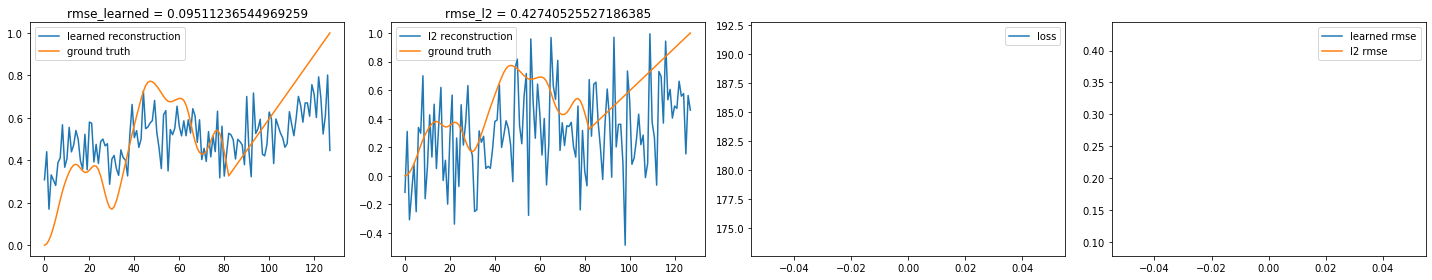

[[Batch 100/1001] [G loss: 55.085678] [Seconds: 1.425955]
[[Batch 200/1001] [G loss: 46.596775] [Seconds: 1.454356]
[[Batch 300/1001] [G loss: 33.022038] [Seconds: 1.435387]
[[Batch 400/1001] [G loss: 29.852909] [Seconds: 1.433222]
[[Batch 500/1001] [G loss: 26.617802] [Seconds: 1.483051]


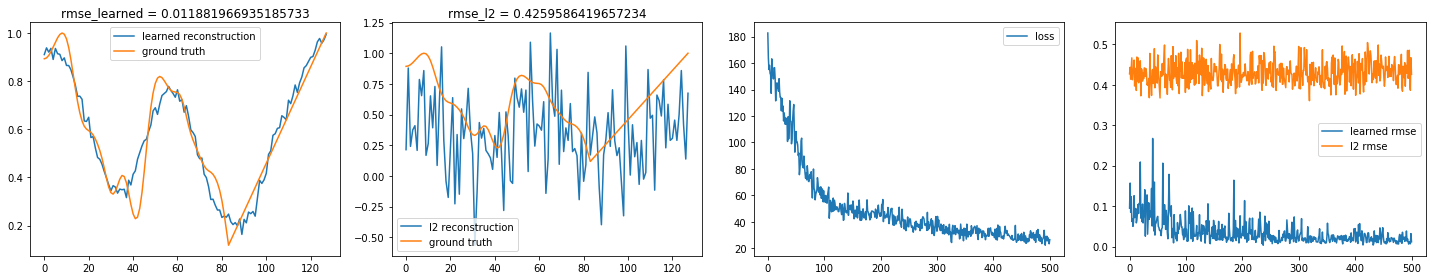

[[Batch 600/1001] [G loss: 22.745268] [Seconds: 1.429065]
[[Batch 700/1001] [G loss: 26.725971] [Seconds: 1.415660]
[[Batch 800/1001] [G loss: 20.439787] [Seconds: 1.436172]
[[Batch 900/1001] [G loss: 20.816664] [Seconds: 1.420305]
[[Batch 1000/1001] [G loss: 23.481762] [Seconds: 1.535054]


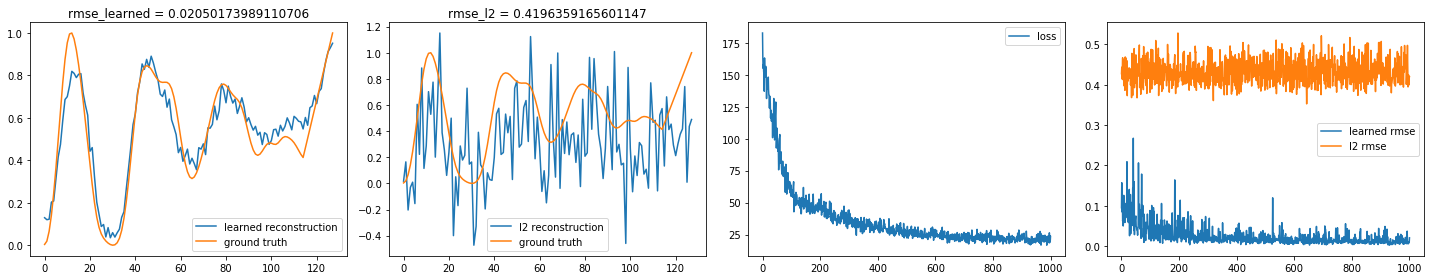

In [14]:
for i in range(n_batches):
    # Load a learning rate from file.
    new_lr = float(np.loadtxt('lr_file'))
    if new_lr != lr:
        lr = new_lr
        print("New lr =", lr)
        for g in optimizer.param_groups:
                g['lr'] = lr

    tick_train_step = time.time()

    # Create a batch of data for training.
    y_delta, delta, x, y = get_noisy_batch(32, relative_delta, function_length)
    y_delta = torch.cuda.FloatTensor(y_delta.T)
    delta = torch.cuda.FloatTensor([delta])
    x = torch.cuda.FloatTensor(x.T)
    y = torch.cuda.FloatTensor(y.T)

    # Initalize x_star as 0
    x_star = Variable(torch.zeros(x.shape, dtype=torch.float32, device='cuda'))

    # Prepare optimizer for batch
    optimizer.zero_grad()

    # Propagate batch
    x_predict = generator(x_star, A_torch, y_delta, delta)

    # Calculate loss
    loss = torch.sum((x - x_predict)**2)

    # Calculate gradients
    loss.backward()

    # Apply gradients
    optimizer.step()

    ####################################################################
    # Print and log progress and compare it with best l2 reconstruction
    if batches_done % 100 == 0:
        print("[[Batch %d/%d] [G loss: %f] [Seconds: %f]"
               % (i, n_batches, loss.item(), time.time() - tick_train_step))
    losses += [loss.item()]


    mse = np.linalg.norm(x_predict.cpu().detach().numpy()[0] - x.cpu().numpy()[0])**2
    rmse = mse / np.linalg.norm(x.cpu().numpy()[0])**2
    example_rmse += [rmse]

    if batches_done % 500 == 0:
        plt.subplot(141), plt.plot(x_predict.detach().cpu().numpy()[0], label="learned reconstruction")
        plt.subplot(141), plt.plot(x.cpu().numpy()[0], label="ground truth")
        plt.subplot(141), plt.title(f"rmse_learned = {rmse}")
        plt.subplot(141), plt.legend()

    x_l2 = get_best_l2(A,
                       y_delta.detach().cpu().numpy()[0],
                       x.detach().cpu().numpy()[0])

    mse_2 = np.linalg.norm(x.detach().cpu().numpy()[0] - x_l2)**2
    rmse_2 = mse_2 / np.linalg.norm(x.detach().cpu().numpy()[0])**2
    example_rmse_l2 += [rmse_2]
    if batches_done % 500 == 0:
        plt.subplot(142), plt.plot(x_l2, label="l2 reconstruction")
        plt.subplot(142), plt.plot(x.cpu().numpy()[0], label="ground truth")
        plt.subplot(142), plt.title(f"rmse_l2 = {rmse_2}")
        plt.subplot(142), plt.legend()

        plt.subplot(143), plt.plot(losses, label="loss")
        plt.subplot(143), plt.legend()

        plt.subplot(144), plt.plot(example_rmse, label="learned rmse")
        plt.subplot(144), plt.plot(example_rmse_l2, label="l2 rmse")
        plt.subplot(144), plt.legend()

        fig = plt.gcf()
        fig.set_size_inches(20, 4)
        plt.tight_layout()
        plt.show()

    batches_done += 1